# Pitcher Control Model: data cleaning, model training, and testing

In [1]:
# Import appropriate libraries

import pandas, json, requests, urllib, io, json
import tensorflow as tf
from tensorflow import keras        
import numpy as np        
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tensorflow.keras import models, layers, Input, optimizers, callbacks
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import random


In [2]:
# Opens pitcher tensors from json file

def get_pitcher_tensors():
    with open('pitcher_tensors.json') as json_file:
        pitcher_tensors = json.load(json_file)
    return pitcher_tensors


pitcher_tensors = get_pitcher_tensors()

In [3]:
# Gets the pitch data csv's for tensor creation from Github

def get_total_pitch_data():

  pitchData = pandas.read_csv("all_pitch.csv", error_bad_lines=False)
  pitchData = pitchData.rename({"res":"result"}, axis = 1)
  del pitchData["zone"]
  pitchData["zone"] = pitchData['zones']
  pitchData["zones"] = pitchData['zones'].map(lambda x: x.rstrip('aAbB')).astype(int)
  
  return pitchData


total_pitch_data = get_total_pitch_data()
total_pitch_data.head()

,Unnamed: 0,px,py,start_speed,code,pitch_type,ab_id,b_count,s_count,batter_id,event,pitcher_id,type,swing,result,zones,zone
0,0,0.416,2.963,92.9,C,FF,2.015000e+09,0.0,0.0,572761,Groundout,452657,S,0,Strike,2,2a
1,1,-0.191,2.347,92.8,S,FF,2.015000e+09,0.0,1.0,572761,Groundout,452657,S,1,Strike,4,4a
2,2,-0.518,3.284,94.1,F,FF,2.015000e+09,0.0,2.0,572761,Groundout,452657,S,1,Foul,0,0a
3,3,-0.641,1.221,91.0,B,FF,2.015000e+09,0.0,2.0,572761,Groundout,452657,B,0,Ball,15,15b
4,4,-1.821,2.083,75.4,B,CU,2.015000e+09,1.0,2.0,572761,Groundout,452657,B,0,Ball,12,12b


In [4]:
# Filters pitches for 3-0 count
def get_filtered_pitches(pitch_df):
    return pitch_df[(pitch_df["b_count"] == 3) & (pitch_df["s_count"] == 0)]
filtered_pitch_df = get_filtered_pitches(total_pitch_data)

In [5]:
# Returns distribution for x and y points
def learn_bivar_gaussian(x,y):
    emp_locs = [np.mean(x),np.mean(y)]
    emp_sigma = np.cov(x,y)
    emp_scale_tril = tf.linalg.cholesky(emp_sigma)
    emp_dist = tfp.distributions.MultivariateNormalTriL(loc=emp_locs,scale_tril = emp_scale_tril)
    
    return emp_dist

In [6]:
# Returns an error distribtion from the .95 most likely pitches
def get_pruned_gaussian(pitcher_id, pitch_type, filtered_df):
    pitcher_filtered_df = filtered_df[(filtered_df["pitcher_id"]==pitcher_id) & (filtered_df["pitch_type"]==pitch_type)]
    x = pitcher_filtered_df["px"].to_numpy()
    y = pitcher_filtered_df["py"].to_numpy()
    orig_gaussian = learn_bivar_gaussian(x,y)
    
    liklihoods = {}
    
    for i in range(len(x)):
        point_x = x[i]
        point_y = y[i]
        p_point = orig_gaussian.prob([point_x,point_y]).numpy()
        liklihoods[p_point] = i
    
    sorted_liklihoods = sorted(liklihoods.keys())
    portion_drop = .05
    num_drop = int(portion_drop*len(x))
    drop_indicies = []
    
    for i in range(num_drop):
        drop_indicies.append(liklihoods[sorted_liklihoods[i]])
    
    pruned_x = []
    pruned_y = []
    for i in range(len(x)):
        if i not in drop_indicies:
            pruned_x.append(x[i])
            pruned_y.append(y[i])
            
    pruned_x = np.array(pruned_x)
    pruned_y = np.array(pruned_y)
    
    pruned_gaussian = learn_bivar_gaussian(pruned_x,pruned_y)
    
    return pruned_gaussian

In [7]:
# Returns dictionary mapping pitchers to train/val/test test
def get_train_val_test_pitchers(pitch_df):
    unique_pitchers = list(pitch_df["pitcher_id"].unique())
    random.seed(0)
    random.shuffle(unique_pitchers)

    counter = 0
    sets = {}
    train_count = 0
    val_count = 0
    test_count = 0
    for i,pitcher in enumerate(unique_pitchers):
        
        if i < len(unique_pitchers)*.7:
            sets[pitcher] = "train"
            train_count+=1
        elif i < len(unique_pitchers) *.85:
            sets[pitcher] = "val"
            val_count+=1
        else:
            sets[pitcher] = "test"
            test_count+=1
       
            
    print(train_count)
    print(val_count)
    print(test_count)
    return sets
train_val_test_sets = get_train_val_test_pitchers(filtered_pitch_df)

845
181
180


In [23]:
# Create list of pitcher ids and number of pitches thrown

test_ids=[]

for pitcher in train_val_test_sets.keys():
    if train_val_test_sets[pitcher] == "test":

        test_ids.append((pitcher,total_pitch_data[total_pitch_data["pitcher_id"]==pitcher].shape[0]))
        
test_ids.sort(key=lambda x: x[1])
test_ids

[(571771, 15),
 (425772, 20),
 (430605, 23),
 (600301, 28),
 (573016, 42),
 (656954, 57),
 (501936, 61),
 (621249, 77),
 (543409, 80),
 (346797, 87),
 (541650, 90),
 (452061, 112),
 (607162, 119),
 (607951, 120),
 (489295, 143),
 (596101, 144),
 (217096, 149),
 (592712, 164),
 (605260, 169),
 (592781, 170),
 (622774, 171),
 (657117, 173),
 (572208, 187),
 (606995, 205),
 (458537, 210),
 (572990, 212),
 (595235, 214),
 (656803, 224),
 (435045, 246),
 (594867, 261),
 (623454, 274),
 (497807, 277),
 (464416, 278),
 (621142, 297),
 (658792, 302),
 (514669, 304),
 (502264, 332),
 (660853, 332),
 (573244, 334),
 (657681, 355),
 (592254, 356),
 (545064, 378),
 (518883, 388),
 (605143, 400),
 (500765, 407),
 (489002, 411),
 (430911, 436),
 (518489, 478),
 (542266, 508),
 (606959, 516),
 (506693, 545),
 (543903, 558),
 (605488, 558),
 (669203, 562),
 (453156, 568),
 (620982, 570),
 (648737, 596),
 (607455, 600),
 (640464, 624),
 (592473, 629),
 (502051, 659),
 (621056, 699),
 (622382, 726),
 (6

In [24]:
# Creates lists for input and output tensors

def get_input_tensors(pitch_df, pitcher_embeddings,train_val_test_sets):
    
    pitches = ['FF', 'SL', 'FT', 'CH', 'FC', 'CU']

    
    train_pitcher = []
    train_pitch = []
    train_mu_x = []
    train_mu_y = []
    train_var_x = []
    train_var_y = []
    train_cov_x_y = []
    
    val_pitcher = []
    val_pitch = []
    val_mu_x = []
    val_mu_y = []
    val_var_x = []
    val_var_y = []
    val_cov_x_y = []
    
    test_pitcher = []
    test_pitch = []
    test_mu_x = []
    test_mu_y = []
    test_var_x = []
    test_var_y = []
    test_cov_x_y = []
    test_ids = []
  
    
    filtered_pitchers = pitch_df["pitcher_id"].unique()
    for i, pitcher in enumerate(filtered_pitchers):
        pitcher_id = pitcher
        pitcher_embedding = pitcher_embeddings[str(pitcher_id)]
        tvt_set = train_val_test_sets[int(pitcher_id)]
        
        pitcher_df = pitch_df[pitch_df["pitcher_id"]==pitcher_id]
        pitch_types = pitcher_df["pitch_type"].unique()
        
        for pitch in pitch_types:
           
            
            shortened_df = pitcher_df[pitcher_df["pitch_type"] == pitch]
            
            if shortened_df.shape[0] > 10:
                pitch_embedding = np.zeros(len(pitches))
                pitch_embedding[pitches.index(pitch)] = 1
                
                pruned_gaussian = get_pruned_gaussian(pitcher,pitch,shortened_df)

                means = pruned_gaussian.mean().numpy()
                cov_mat = pruned_gaussian.covariance().numpy()
                mu_x = means[0]
                mu_y = means[1]
                var_x = cov_mat[0][0]
                var_y = cov_mat[1][1]
                cov_x_y = cov_mat[0][1]
                
      


                if tvt_set == "train":
                    train_pitcher.append(pitcher_embedding)
                    train_pitch.append(pitch_embedding)
                    train_mu_x.append(mu_x)
                    train_mu_y.append(mu_y)
                    train_var_x.append(var_x)
                    train_var_y.append(var_y)
                    train_cov_x_y.append(cov_x_y)
                elif tvt_set == "val":
                    val_pitcher.append(pitcher_embedding)
                    val_pitch.append(pitch_embedding)
                    val_mu_x.append(mu_x)
                    val_mu_y.append(mu_y)
                    val_var_x.append(var_x)
                    val_var_y.append(var_y)
                    val_cov_x_y.append(cov_x_y)
                elif tvt_set == "test":
                    test_pitcher.append(pitcher_embedding)
                    test_pitch.append(pitch_embedding)
                    test_mu_x.append(mu_x)
                    test_mu_y.append(mu_y)
                    test_var_x.append(var_x)
                    test_var_y.append(var_y)
                    test_cov_x_y.append(cov_x_y)
                    test_ids.append((pitcher_id, pitch))
        
    print(len(train_pitcher))
    print(len(val_pitcher))
    print(len(test_pitcher))
    tensors={
        "train":{
            "pitcher" : np.array(train_pitcher),
            "pitch" : np.array(train_pitch),
            "mu_x" : np.array(train_mu_x),
            "mu_y" : np.array(train_mu_y),
            "var_x" : np.array(train_var_x),
            "var_y" : np.array(train_var_y),
            "cov_x_y" : np.array(train_cov_x_y)
        },
        "val":{
            "pitcher" : np.array(val_pitcher),
            "pitch" : np.array(val_pitch),
            "mu_x" : np.array(val_mu_x),
            "mu_y" : np.array(val_mu_y),
            "var_x" : np.array(val_var_x),
            "var_y" : np.array(val_var_y),
            "cov_x_y" : np.array(val_cov_x_y)
        },
        "test":{
            "pitcher" : np.array(test_pitcher),
            "pitch" : np.array(test_pitch),
            "mu_x" : np.array(test_mu_x),
            "mu_y" : np.array(test_mu_y),
            "var_x" : np.array(test_var_x),
            "var_y" : np.array(test_var_y),
            "cov_x_y" : np.array(test_cov_x_y),
            "ids": np.array(test_ids)
        }
    }
   
    return tensors


tensors = get_input_tensors(filtered_pitch_df, pitcher_tensors, train_val_test_sets)        

552
115
118


In [25]:
# Creates indiviudal lists from i/o tensor dictionaries

train_pitcher = tensors["train"]["pitcher"]
train_pitch = tensors["train"]["pitch"]
train_mu_x = tensors["train"]["mu_x"]
train_mu_y = tensors["train"]["mu_y"]
train_var_x = tensors["train"]["var_x"]
train_var_y = tensors["train"]["var_y"]
train_cov_x_y = tensors["train"]["cov_x_y"]

val_pitcher = tensors["val"]["pitcher"]
val_pitch = tensors["val"]["pitch"]
val_mu_x = tensors["val"]["mu_x"]
val_mu_y = tensors["val"]["mu_y"]
val_var_x = tensors["val"]["var_x"]
val_var_y = tensors["val"]["var_y"]
val_cov_x_y = tensors["val"]["cov_x_y"]

test_pitcher = tensors["test"]["pitcher"]
test_pitch = tensors["test"]["pitch"]
test_mu_x = tensors["test"]["mu_x"]
test_mu_y = tensors["test"]["mu_y"]
test_var_x = tensors["test"]["var_x"]
test_var_y = tensors["test"]["var_y"]
test_cov_x_y = tensors["test"]["cov_x_y"]
test_ids = tensors["test"]["ids"]

In [ ]:
def randomize_order(train_pitcher, train_pitch, train_mu_x, train_mu_y, train_var_x, train_var_y, train_cov_x_y):
  together = list(zip(list(train_pitcher), list(train_pitch), list(train_mu_x), list(train_mu_y), list(train_var_x), list(train_var_y), list(train_cov_x_y)))
  import random
  random.shuffle(together)
  train_pitcher, train_pitch, train_mu_x, train_mu_y, train_var_x, train_var_y, train_cov_x_y = zip(*together)
  return list(train_pitcher), list(train_pitch), list(train_mu_x), list(train_mu_y), list(train_var_x), list(train_var_y), list(train_cov_x_y)


train_pitcher, train_pitch, train_mu_x, train_mu_y, train_var_x, train_var_y, train_cov_x_y = randomize_order(train_pitcher, train_pitch, train_mu_x, train_mu_y, train_var_x, train_var_y, train_cov_x_y)
train_pitcher = np.array(train_pitcher)
train_pitch = np.array(train_pitch)
train_mu_x = np.array(train_mu_x)
train_mu_y = np.array(train_mu_y)
train_var_x = np.array(train_var_x)
train_var_y = np.array(train_var_y)
train_cov_x_y = np.array(train_cov_x_y)

In [ ]:
## DEFINE THE MODEL


#Network Input: Pitcher embedding
p_input = Input(shape=(5, 5, 12), dtype='float32', name='pitcher')
p_conv_1 = layers.Conv2D(32, (4, 4), activation='relu', padding='same', name='p_conv_1')(p_input)
p_conv_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='p_conv_2')(p_conv_1)
p_conv_3 = layers.Conv2D(32, (2, 2), activation='relu', padding='same', name='p_conv_3')(p_conv_2)
p_maxpool_1 = layers.MaxPooling2D((2,2), padding='same', name='p_maxpool_1')(p_conv_1)
p_conv_4 = layers.Conv2D(64, (2,5), activation='relu', padding='same', name='p_conv_4')(p_maxpool_1)
p_maxpool_2 = layers.MaxPooling2D((2,2), padding='same', name='p_maxpool_2')(p_conv_4)
p_conv_5 = layers.Conv2D(64, (2,4), activation='relu', padding='same', name='p_conv_5')(p_maxpool_2)
p_maxpool_3 = layers.MaxPooling2D((2,2), padding='same', name='p_maxpool_3')(p_conv_5)
p_conv_6 = layers.Conv2D(64, (2,3), activation='relu', padding='same', name='p_conv_6')(p_maxpool_3)
p_maxpool_4 = layers.MaxPooling2D((2,2), padding='same', name='p_maxpool_4')(p_conv_6)
p_conv_7 = layers.Conv2D(64, (2,2), activation='relu', padding='same', name='p_conv_7')(p_maxpool_4)
p_maxpool_5 = layers.MaxPooling2D((2,2), padding='same', name='p_maxpool_5')(p_conv_7)
flat_pitcher = layers.Flatten(name='flatten_pitcher')(p_maxpool_5)
 
input_pitch_embedding = Input(shape=(6))

concatenated = layers.concatenate([flat_pitcher, input_pitch_embedding], name='concat')


#Dense Layers

Layer_1 = layers.Dense(100,activation="sigmoid")(concatenated)
Layer_2 = layers.Dense(50, activation = "sigmoid")(Layer_1)
Layer_3 = layers.Dense(25,activation="sigmoid")(Layer_2)

#Output Layers
mu_x = layers.Dense(1, activation="linear")(Layer_3)
mu_y = layers.Dense(1, activation="linear")(Layer_3)
var_x = layers.Dense(1, activation="linear")(Layer_3)
var_y = layers.Dense(1, activation="linear")(Layer_3)
cov_x_y = layers.Dense(1, activation="linear")(Layer_3)


model = models.Model(inputs=[p_input, input_pitch_embedding], outputs=[mu_x, mu_y, var_x, var_y, cov_x_y])
model.summary()

In [81]:
# Compile the model

model.compile(optimizer="adam", loss = "mse")
history_cache = model.fit([train_pitcher, train_pitch],
                          [train_mu_x, train_mu_y, train_var_x, train_var_y, train_cov_x_y],
                          validation_data = ([val_pitcher, val_pitch],[val_mu_x, val_mu_y, val_var_x, val_var_y, val_cov_x_y]),
                          epochs=50,
                          batch_size=1)

Epoch 1/50
552/552 [==============================] - 2s 2ms/step - loss: 0.5751 - dense_35_loss: 0.0706 - dense_36_loss: 0.2682 - dense_37_loss: 0.0537 - dense_38_loss: 0.0708 - dense_39_loss: 0.1118 - val_loss: 0.2565 - val_dense_35_loss: 0.0751 - val_dense_36_loss: 0.0550 - val_dense_37_loss: 0.0405 - val_dense_38_loss: 0.0498 - val_dense_39_loss: 0.0362
Epoch 2/50
552/552 [==============================] - 1s 2ms/step - loss: 0.2472 - dense_35_loss: 0.0687 - dense_36_loss: 0.0564 - dense_37_loss: 0.0325 - dense_38_loss: 0.0540 - dense_39_loss: 0.0356 - val_loss: 0.2520 - val_dense_35_loss: 0.0629 - val_dense_36_loss: 0.0538 - val_dense_37_loss: 0.0424 - val_dense_38_loss: 0.0549 - val_dense_39_loss: 0.0380
Epoch 3/50
552/552 [==============================] - 1s 2ms/step - loss: 0.2492 - dense_35_loss: 0.0701 - dense_36_loss: 0.0561 - dense_37_loss: 0.0320 - dense_38_loss: 0.0544 - dense_39_loss: 0.0366 - val_loss: 0.2424 - val_dense_35_loss: 0.0631 - val_dense_36_loss: 0.0574 - va

Epoch 24/50
552/552 [==============================] - 1s 2ms/step - loss: 0.2079 - dense_35_loss: 0.0524 - dense_36_loss: 0.0519 - dense_37_loss: 0.0308 - dense_38_loss: 0.0527 - dense_39_loss: 0.0201 - val_loss: 0.2426 - val_dense_35_loss: 0.0620 - val_dense_36_loss: 0.0477 - val_dense_37_loss: 0.0456 - val_dense_38_loss: 0.0473 - val_dense_39_loss: 0.0401
Epoch 25/50
552/552 [==============================] - 1s 2ms/step - loss: 0.2059 - dense_35_loss: 0.0537 - dense_36_loss: 0.0502 - dense_37_loss: 0.0308 - dense_38_loss: 0.0521 - dense_39_loss: 0.0191 - val_loss: 0.2319 - val_dense_35_loss: 0.0620 - val_dense_36_loss: 0.0472 - val_dense_37_loss: 0.0402 - val_dense_38_loss: 0.0488 - val_dense_39_loss: 0.0336
Epoch 26/50
552/552 [==============================] - 1s 2ms/step - loss: 0.2050 - dense_35_loss: 0.0522 - dense_36_loss: 0.0497 - dense_37_loss: 0.0311 - dense_38_loss: 0.0527 - dense_39_loss: 0.0194 - val_loss: 0.2412 - val_dense_35_loss: 0.0595 - val_dense_36_loss: 0.0527 -

Epoch 47/50
552/552 [==============================] - 1s 2ms/step - loss: 0.1800 - dense_35_loss: 0.0452 - dense_36_loss: 0.0406 - dense_37_loss: 0.0290 - dense_38_loss: 0.0476 - dense_39_loss: 0.0176 - val_loss: 0.2529 - val_dense_35_loss: 0.0641 - val_dense_36_loss: 0.0583 - val_dense_37_loss: 0.0426 - val_dense_38_loss: 0.0546 - val_dense_39_loss: 0.0334
Epoch 48/50
552/552 [==============================] - 1s 2ms/step - loss: 0.1810 - dense_35_loss: 0.0456 - dense_36_loss: 0.0399 - dense_37_loss: 0.0295 - dense_38_loss: 0.0485 - dense_39_loss: 0.0176 - val_loss: 0.2414 - val_dense_35_loss: 0.0633 - val_dense_36_loss: 0.0518 - val_dense_37_loss: 0.0398 - val_dense_38_loss: 0.0539 - val_dense_39_loss: 0.0326
Epoch 49/50
552/552 [==============================] - 1s 2ms/step - loss: 0.1785 - dense_35_loss: 0.0445 - dense_36_loss: 0.0393 - dense_37_loss: 0.0288 - dense_38_loss: 0.0476 - dense_39_loss: 0.0183 - val_loss: 0.2446 - val_dense_35_loss: 0.0593 - val_dense_36_loss: 0.0567 -

In [82]:
# Save the model

model.save("error_2015-2018.h5")

In [15]:
# Generate predictions for test set

network_test = keras.models.load_model("error_2015-2018.h5")


pred_results = np.array(network_test.predict([test_pitcher, test_pitch]))

    
error_dict={
    "pitcher_test":test_pitcher.tolist(),
    "mu_x_test":test_mu_x.tolist(),
    "mu_y_test":test_mu_y.tolist(),
    "var_x_test":test_var_x.tolist(),
    "var_y_test":test_var_y.tolist(),
    "cov_x_y_test":test_cov_x_y.tolist(),
    "pitch_set_test":test_pitch.tolist(),
    "pred_test":pred_results.tolist(),
    "ids_test":test_ids.tolist()
}
    
with open("error_test_predictions.json", "w") as outfile: 
    json.dump(error_dict, outfile)
print("SAVED")

SAVED


In [12]:
# Calculates mean squared error between two arrays

def calc_mse(array_1,array_2):
    diff = array_1 - array_2
    return np.mean(np.square(diff))

In [13]:
# Open test predictions and print MSE for the three learned parameters
with open("error_test_predictions.json") as infile:
    test_set = json.load(infile)
true_var_x = np.array(test_set["var_x_test"])
true_var_y = np.array(test_set["var_y_test"])
true_cov_x_y= np.array(test_set["cov_x_y_test"])

pred_test = np.array(test_set["pred_test"])

pred_var_x = pred_test[2,:,0]
pred_var_y = pred_test[3,:,0]
pred_cov_x_y = pred_test[4,:,0]


var_x_mse = calc_mse(true_var_x, pred_var_x)
var_y_mse = calc_mse(true_var_y, pred_var_y)
cov_x_y_mse = calc_mse(true_cov_x_y, pred_cov_x_y)

print("Variance X MSE")
print(var_x_mse)
print("Variance Y MSE")
print(var_y_mse)
print("Covariance MSE")
print(cov_x_y_mse)


Variance X MSE
0.03642736400596464
Variance Y MSE
0.052512825657675385
Covariance MSE
0.025101981565715997


In [48]:
# Open test predictions and aggregate across pitcher quality for fourseem fastball ("FF")


with open("error_test_predictions.json") as infile:
    test_set = json.load(infile)
    
    
with open("thirds.json") as infile:
    thirds = json.load(infile)
    
    
true_var_x = np.array(test_set["var_x_test"])
true_var_y = np.array(test_set["var_y_test"])
true_cov_x_y= np.array(test_set["cov_x_y_test"])

pred_test = np.array(test_set["pred_test"])

pred_var_x = pred_test[2,:,0]
pred_var_y = pred_test[3,:,0]
pred_cov_x_y = pred_test[4,:,0]

counter = 0
grouping_values = {}
grouping_values[0] = {"emp":[],"pred":[]}
grouping_values[1] = {"emp":[],"pred":[]}
grouping_values[2] = {"emp":[],"pred":[]}
for i in range(len(test_set["pitcher_test"])):
    if test_set["ids_test"][i][1] == "FF":
        counter+=1
        print(counter)
        pitcher_id = str(test_set["ids_test"][i][0])
        group = thirds["pitchers"][pitcher_id]
        grouping_values[group]["emp"].append([test_set["var_x_test"][i],test_set["var_y_test"][i],test_set["cov_x_y_test"][i]])
        grouping_values[group]["pred"].append([pred_var_x[i],pred_var_y[i],pred_cov_x_y[i]])
    

    
    

grouping_averages = {}
grouping_averages[0] = {"emp":[],"pred":[]}
grouping_averages[1] = {"emp":[],"pred":[]}
grouping_averages[2] = {"emp":[],"pred":[]}

for group in grouping_values.keys():
    emp_vals = np.array(grouping_values[group]["emp"])
    pred_vals = np.array(grouping_values[group]["pred"])
    grouping_averages[group]["emp"]=np.mean(emp_vals,axis=0)
    grouping_averages[group]["pred"]=np.mean(pred_vals,axis=0)
    print(group)
    print(len(emp_vals))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
0
11
1
39
2
31


In [35]:
# Import plotting libraries and set format for Latex

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("pdf")
matplotlib.rcParams.update({
    'font.family': 'serif',
})

0.5514137530681257
0.46129307702363204
0.4453319192397472
0.4960312707857652
0.4738172178085034
0.46435036101648886
0.6698677740246848
0.5398546446067398
0.5278880313565794
0.5922528938813643
0.5737750178728348
0.554030022313518


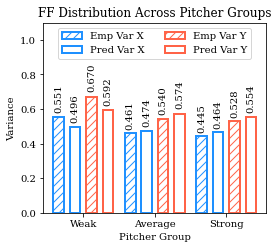

In [47]:
# Plot distribution paramters across groups of pitcher skill

emp_var_x = []
emp_var_y = []

pred_var_x = []
pred_var_y = []


for group in grouping_averages.keys():
    emp_var_x.append(grouping_averages[group]["emp"][0])
    emp_var_y.append(grouping_averages[group]["emp"][1])

    pred_var_x.append(grouping_averages[group]["pred"][0])
    pred_var_y.append(grouping_averages[group]["pred"][1])

    
width = 0.15  # the width of the bars
dist = .08


groups = ["Weak","Average","Strong"]



x = np.arange(len(groups))
fig, ax = plt.subplots()
fig.set_size_inches(w=4, h=3.5)
rects1 = ax.bar(x - width-width*1/2-dist-dist*1/2, emp_var_x, width, label='Emp Var X', edgecolor= "dodgerblue",hatch="///", color="white", alpha = .99, linewidth=2)
rects2 = ax.bar(x-width*1/2 -dist*1/2, pred_var_x, width, label='Pred Var X',color="white", edgecolor= "dodgerblue",linewidth=2)
rects3 = ax.bar(x + width-width*1/2+dist*1/2, emp_var_y, width, label='Emp Var Y', edgecolor= "tomato",color="white",hatch="///", alpha = .99,linewidth=2)
rects4 = ax.bar(x + width*2-width*1/2 +dist+dist*1/2, pred_var_y, width, label='Pred Var Y', color="white",edgecolor= "tomato",linewidth=2)


ax.set_ylabel("Variance")
ax.set_xlabel("Pitcher Group")
ax.set_title('FF Distribution Across Pitcher Groups')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()
plt.ylim((0,1.1))


#fig.tight_layout()

def autolabel(bars):

    for bar in bars:
        height = bar.get_height()
        print(height)
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%.3f' % float(height), rotation=90,
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
plt.legend(loc="upper center", ncol = 2)
plt.show()
plt.savefig('fourseem_dist.pdf',dpi=120)

In [ ]:
# Plots countour lines of empirical and predicted distributions 

import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(pitcher_id,pitch_type)






    pruned_gaussian = get_pruned_gaussian(pitcher_id,pitch_type,filtered_pitch_df)


    fig, ax = plt.subplots()

    emp_locs = pruned_gaussian.mean().numpy()
    emp_sigma = pruned_gaussian.covariance().numpy()
    emp_scale_tril = tf.linalg.cholesky(emp_sigma)
    emp_dist = tfp.distributions.MultivariateNormalTriL(loc=emp_locs,scale_tril = emp_scale_tril)

    print(emp_sigma)
    N= 100000

    emp_x = emp_dist.sample(N)
    emp_x1 = emp_x[:, 0].numpy()
    emp_x2 = emp_x[:, 1].numpy()




    pitcher_embedding = np.array(pitcher_tensors[str(pitcher_id)])
    pitches = ['FF', 'SL', 'FT', 'CH', 'FC', 'CU']
    pitch = np.zeros(6)
    pitch[pitches.index(pitch_type)] = 1

    mu_x_pred, mu_y_pred, var_x_pred, var_y_pred, cov_x_y_pred = network_test.predict([np.array([pitcher_embedding]),np.array([pitch])])

    locs = [mu_x_pred[0][0],mu_y_pred[0][0]]
    sigma = [[var_x_pred[0][0], cov_x_y_pred[0][0]],
             [cov_x_y_pred[0][0], var_y_pred[0][0]]]
    scale_tril = tf.linalg.cholesky(sigma)
    dist = tfp.distributions.MultivariateNormalTriL(loc=locs,scale_tril = scale_tril)

    print(sigma)
    N = 100000
    x = dist.sample(N)
    x1 = x[:, 0].numpy()
    x2 = x[:, 1].numpy()

    plt.title("Emperically Derived (Blue) vs Predicted (Red) Guassian")
    sns.kdeplot(x1, x2, color = "red")
    sns.kdeplot(emp_x1, emp_x2, color = "blue")

[[ 1.154       2.208     ]
 [ 0.683       2.377     ]
 [-0.295       2.909     ]
 [-0.102       1.905     ]
 [-0.707       2.15      ]
 [-0.675       1.563     ]
 [ 0.22        2.58      ]
 [ 0.295       1.421     ]
 [ 0.068       2.802     ]
 [ 0.218       2.273     ]
 [ 0.807       2.437     ]
 [ 0.044       2.106     ]
 [ 0.145       2.268     ]
 [-0.019       2.316     ]
 [ 0.875       1.875     ]
 [-0.776       2.177     ]
 [ 0.29        2.18      ]
 [ 1.004       3.497     ]
 [-1.224       2.199     ]
 [ 0.452       2.113     ]
 [ 0.669       2.967     ]
 [ 0.562       3.214     ]
 [-0.075       1.482     ]
 [ 0.015       2.16      ]
 [ 0.593       2.549     ]
 [-0.049       2.046     ]
 [-0.01034546  1.58646972]
 [-0.29638453  3.08902473]
 [-0.55272552  3.25144822]
 [ 0.42531971  3.48387702]
 [-0.52244166  2.47804807]
 [ 0.39642886  1.70902556]
 [ 0.62836756  2.01438282]
 [ 0.83710703  3.36592316]
 [-0.2464026   2.16089022]
 [-0.05684438  3.62938235]
 [-0.62740082  2.04676073]
 

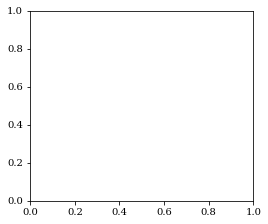

In [45]:
# Creates distributions across zones for a given pitcher and pitch type for empirical pitches thrown, empirically learned pruned Gaussian distribution, and predicted pruned Gaussian distribution

pitcher_id = 461829
pitch_type = "FF"
network_test = keras.models.load_model("error_2015-2018.h5")

pruned_gaussian = get_pruned_gaussian(pitcher_id,pitch_type,filtered_pitch_df)


fig, ax = plt.subplots(figsize=(4,3.5))


data = filtered_pitch_df[(filtered_pitch_df["pitcher_id"]==pitcher_id) & (filtered_pitch_df["pitch_type"]==pitch_type)][["px","py"]].to_numpy()
print(data)
x1 = data[:, 0]
x2 = data[:, 1]



emp_locs = pruned_gaussian.mean().numpy()
emp_sigma = pruned_gaussian.covariance().numpy()
emp_scale_tril = tf.linalg.cholesky(emp_sigma)
emp_dist = tfp.distributions.MultivariateNormalTriL(loc=emp_locs,scale_tril = emp_scale_tril)
print(emp_locs)
print(emp_sigma)
N= 100000

emp_x = emp_dist.sample(N)
emp_x1 = emp_x[:, 0].numpy()
emp_x2 = emp_x[:, 1].numpy()


pitcher_embedding = np.array(pitcher_tensors[str(pitcher_id)])
pitches = ['FF', 'SL', 'FT', 'CH', 'FC', 'CU']
pitch = np.zeros(6)
pitch[pitches.index(pitch_type)] = 1

mu_x_pred, mu_y_pred, var_x_pred, var_y_pred, cov_x_y_pred = network_test.predict([np.array([pitcher_embedding]),np.array([pitch])])

locs = [mu_x_pred[0][0],mu_y_pred[0][0]]
sigma = [[var_x_pred[0][0], cov_x_y_pred[0][0]],
         [cov_x_y_pred[0][0], var_y_pred[0][0]]]
scale_tril = tf.linalg.cholesky(sigma)
pred_dist = tfp.distributions.MultivariateNormalTriL(loc=locs,scale_tril = scale_tril)

print(sigma)

pred_data = pred_dist.sample(N)
pred_x1 = pred_data[:, 0].numpy()
pred_x2 = pred_data[:, 1].numpy()






def get_zone(x,y):
    LEFT_X = -0.831
    MID_LEFT_X = -0.277
    MID_RIGHT_X = 0.277
    RIGHT_X = 0.831

    TOP_Y = 1.074 +2.599
    MID_TOP_Y = 0.358 +2.599
    MID_BOT_Y = -0.358 +2.599
    BOT_Y = -1.074 +2.599
    
    
    if x< LEFT_X:
        if y< BOT_Y:
            return 14
        elif y<MID_BOT_Y:
            return 12
        elif y<MID_TOP_Y:
            return 12
        elif y<TOP_Y:
            return 12
        else:
            return 9
    elif x<MID_LEFT_X:
        if y< BOT_Y:
            return 15
        elif y<MID_BOT_Y:
            return 6
        elif y<MID_TOP_Y:
            return 3
        elif y<TOP_Y:
            return 0
        else:
            return 10
    elif x<MID_RIGHT_X:
        if y< BOT_Y:
            return 15   
        elif y<MID_BOT_Y:
            return 7
        elif y<MID_TOP_Y:
            return 4
        elif y<TOP_Y:
            return 1
        else:
            return 10
    elif x<RIGHT_X:
        if y< BOT_Y:
            return 15    
        elif y<MID_BOT_Y:
            return 8
        elif y<MID_TOP_Y:
            return 5
        elif y<TOP_Y:
            return 2
        else:
            return 10
    else:
        if y< BOT_Y:
            return 16
        elif y<MID_BOT_Y:
            return 13   
        elif y<MID_TOP_Y:
            return 13
        elif y<TOP_Y:
            return 13
        else: 
            return 11
        
sample = np.zeros((len(emp_x),2))
sample[:,0] = emp_x1
sample[:,1] = emp_x2


dist_zones = []

LEFT_X = -0.831
MID_LEFT_X = -0.277
MID_RIGHT_X = 0.277
RIGHT_X = 0.831

TOP_Y = 1.074 +2.599
MID_TOP_Y = 0.358 +2.599
MID_BOT_Y = -0.358 +2.599
BOT_Y = -1.074 +2.599


emp_zones = []

for point in data:
    x = point[0]
    y = point[1]
    zone = get_zone(x,y)
    emp_zones.append(zone)
    

dist_zones = []

for point in sample:
    x = point[0]
    y = point[1]
    zone = get_zone(x,y)
    dist_zones.append(zone)



pred_zones = []

for point in pred_data:
    x = point[0]
    y = point[1]
    zone = get_zone(x,y)
    pred_zones.append(zone)
    
emp_zone_counts = pandas.Series(np.array(emp_zones)).value_counts(normalize = True)
    
dist_zone_counts = pandas.Series(np.array(dist_zones)).value_counts(normalize = True)

pred_zone_counts = pandas.Series(np.array(pred_zones)).value_counts(normalize = True)

    
def get_x_y_zone_frequencies(series):
    data = {1:{},2:{},3:{},4:{},5:{}}
    
    
    for zone, freq in series.iteritems():
    
    
        if zone == 0:
            data[2][4] = freq
        if zone == 1:
            data[3][4] = freq
        if zone == 2:
            data[4][4] = freq
        if zone == 3:
            data[2][3] = freq
        if zone == 4:
            data[3][3] = freq
        if zone == 5:
            data[4][3] = freq
        if zone == 6:
            data[2][2] = freq
        if zone == 7:
            data[3][2] = freq
        if zone == 8:
            data[4][2] = freq
        if zone == 9:
            data[1][5] = freq
        if zone == 10:
            data[2][5] = freq
            data[3][5] = freq
            data[4][5] = freq
        if zone == 11:
            data[5][5] = freq
        if zone == 12:
            data[1][2] = freq
            data[1][3] = freq
            data[1][4] = freq
        if zone == 13:
            data[5][2] = freq
            data[5][3] = freq
            data[5][4] = freq
        if zone == 14:
            data[1][1] = freq
        if zone == 15:
            data[2][1] = freq
            data[3][1] = freq
            data[4][1] = freq
        if zone == 16:
            data[5][1] = freq
    return pandas.DataFrame.from_dict(data).sort_index(axis = 0, ascending=False)


import seaborn  as sns

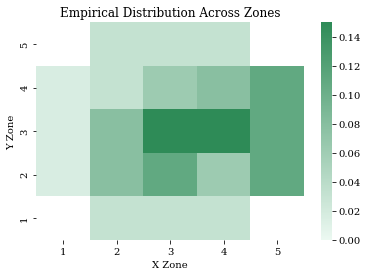

In [41]:
# Graphs empirical distribution
emp_df = get_x_y_zone_frequencies(emp_zone_counts)
plt.title("Empirical Distribution Across Zones")

fig2 = sns.heatmap(emp_df, cmap =sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=.15)

plt.xlabel("X Zone")
plt.ylabel("Y Zone")
plt.savefig("empirical_dist.pdf")

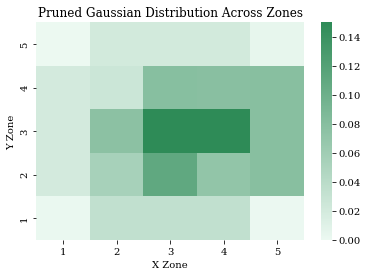

In [42]:
# Graphs samples from empirical pruned Gaussian distribution
dist_df = get_x_y_zone_frequencies(dist_zone_counts)
plt.title("Pruned Gaussian Distribution Across Zones")
fig2 = sns.heatmap(dist_df,cmap =sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=.15)
plt.xlabel("X Zone")
plt.ylabel("Y Zone")
plt.savefig("gaussian_dist.pdf")

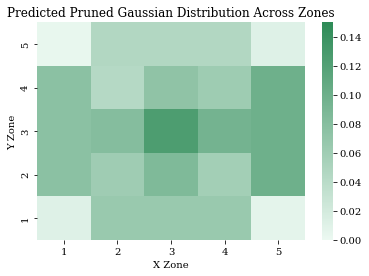

In [44]:
# Graphs samples from predicted pruned Gaussian distribution
pred_df = get_x_y_zone_frequencies(pred_zone_counts)
plt.title("Predicted Pruned Gaussian Distribution Across Zones")
fig2 = sns.heatmap(pred_df,cmap =sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=.15)
plt.xlabel("X Zone")
plt.ylabel("Y Zone")
plt.savefig("pred_gaussian_dist.pdf")